# FAST-UAV - Fixed-Wing Design Optimization

[FAST-OAD](https://fast-oad.readthedocs.io) is a framework for performing rapid Overall Aircraft Design. The computational core of FAST-OAD is based on the  [OpenMDAO framework](https://openmdao.org/). <br>
FAST-UAV is the drone declination of FAST-OAD.

## 1. Setting up and analyzing the initial problem

To organize our work, we propose to use two user folders `data/` and `workdir/`. For instance, in `data/` we store a XML file which describes the [DJI Matrice 600 Pro](https://www.dji.com/matrice600-pro) multicopter. In `workdir/`, we store files generated or modified by FAST-UAV.

In [1]:
import os.path as pth
import openmdao.api as om
import logging
import shutil
import fastoad.api as oad
from time import time
import matplotlib.pyplot as plt
from utils.postprocessing.analysis_and_plots import *

plt.rcParams["figure.figsize"] = 16, 8
plt.rcParams.update({"font.size": 13})

DATA_FOLDER_PATH = "data"
WORK_FOLDER_PATH = "workdir"

CONFIGURATION_FILE = pth.join(DATA_FOLDER_PATH, "fixedwing_mdo.yaml")
SOURCE_FILE = pth.join(DATA_FOLDER_PATH, "problem_inputs_FW.xml")

# For having log messages display on screen
logging.basicConfig(level=logging.INFO, format="%(levelname)-8s: %(message)s")

# For using all screen width
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

D:\Softwares\Anaconda3\envs\OAD\lib\site-packages\pyoptsparse\pyOpt_MPI.py:68: UserWarning: mpi4py could not be imported. mpi4py is required to use the parallel gradient analysis and parallel objective analysis for non-gradient based optimizers. Continuing using a dummy MPI module from pyOptSparse.
  warnings.warn(warn)


The YAML configuration file located in the [data folder](./data/) defines the design problem, i.e. the model, the problem driver and the optimization problem definition.<br>
A useful feature is the [N2 diagram](http://openmdao.org/twodocs/versions/latest/basic_guide/make_n2.html) visualization available in OpenMDAO to see the structure of the model:

In [2]:
N2_FILE = pth.join(WORK_FOLDER_PATH, "n2.html")
oad.write_n2(CONFIGURATION_FILE, N2_FILE, overwrite=True)
from IPython.display import IFrame
IFrame(src=N2_FILE, width="100%", height="500px")

INFO    : N2 diagram written in D:\THESE\Tools\FAST-ODD\workdir\n2.html


In the configuration file, we have specified an input file name 'problem_inputs.xml'. We can ask FAST-UAV to generate the inputs of the model with the reference parameters from 'problem_inputs_DJI_M600.xml' as default values:

In [3]:
oad.generate_inputs(CONFIGURATION_FILE, SOURCE_FILE, overwrite=True)

INFO    : Loaded variable descriptions in D:\THESE\Tools\FAST-ODD\data\../models
INFO    : Loading bundles from D:\THESE\Tools\FAST-ODD\data\../models
INFO    : Installed bundle models (ID 194 )
INFO    : Loading bundles from D:\THESE\Tools\FAST-ODD\data\../models/Missions
INFO    : Installed bundle Missions (ID 195 )
INFO    : Installed bundle Missions.mission_design (ID 197 )
INFO    : Installed bundle Missions.mission_concordia (ID 196 )
INFO    : Loading bundles from D:\THESE\Tools\FAST-ODD\data\../models/Scenarios
INFO    : Installed bundle Scenarios.sizing_scenarios (ID 201 )
INFO    : Installed bundle Scenarios (ID 198 )
INFO    : Installed bundle Scenarios.architecture (ID 199 )
INFO    : Installed bundle Scenarios.atmosphere (ID 200 )
INFO    : Loading bundles from D:\THESE\Tools\FAST-ODD\data\../models/System
INFO    : Installed bundle System (ID 202 )
INFO    : Installed bundle System.system (ID 203 )
INFO    : Loading bundles from D:\THESE\Tools\FAST-ODD\data\../models/Prop

'D:\\THESE\\Tools\\FAST-ODD\\workdir\\problem_inputs.xml'

You can now checkout the generated [input file](./workdir/problem_inputs.xml). The values in this file can be modified by the user and will be considered by FAST-UAV when executing a computational process.<br>
The `variable-viewer` provides a way to inspect and modify the content of the XML file. The dropdown lists above the table allow to filter the displayed variable.

In [4]:
INPUT_FILE = pth.join(WORK_FOLDER_PATH, "problem_inputs.xml")
oad.variable_viewer(INPUT_FILE)

## 2. Running an MDO

You can now run an optimization problem. The last part of the configuration file .yaml is where this optimization problem is defined:

```yaml
optimization:
  design_variables:
    - name: data:system:MTOW:k # over estimation coefficient on the load mass
      upper: 40.0
      lower: 1.0
  constraints:
    - name: data:system:constraints:mass:convergence # mass consistency
      lower: 0.0
  objective:
    - name: data:system:MTOW
      scaler: 1e-1
```

In [92]:
optim_problem = oad.optimize_problem(CONFIGURATION_FILE, overwrite=True)
# optim_problem = oad.evaluate_problem(CONFIGURATION_FILE, overwrite=True)

INFO    : Loaded variable descriptions in D:\THESE\Tools\FAST-ODD\data\../models
INFO    : Loading bundles from D:\THESE\Tools\FAST-ODD\data\../models
INFO    : Installed bundle models (ID 194 )
INFO    : Loading bundles from D:\THESE\Tools\FAST-ODD\data\../models/Missions
INFO    : Installed bundle Missions (ID 195 )
INFO    : Installed bundle Missions.mission_design (ID 197 )
INFO    : Installed bundle Missions.mission_concordia (ID 196 )
INFO    : Loading bundles from D:\THESE\Tools\FAST-ODD\data\../models/Scenarios
INFO    : Installed bundle Scenarios.sizing_scenarios (ID 201 )
INFO    : Installed bundle Scenarios (ID 198 )
INFO    : Installed bundle Scenarios.architecture (ID 199 )
INFO    : Installed bundle Scenarios.atmosphere (ID 200 )
INFO    : Loading bundles from D:\THESE\Tools\FAST-ODD\data\../models/System
INFO    : Installed bundle System (ID 202 )
INFO    : Installed bundle System.system (ID 203 )
INFO    : Loading bundles from D:\THESE\Tools\FAST-ODD\data\../models/Prop

Optimization terminated successfully    (Exit mode 0)
            Current function value: [1.07768553]
            Iterations: 67
            Function evaluations: 75
            Gradient evaluations: 67
Optimization Complete
-----------------------------------


INFO    : Problem outputs written in D:\THESE\Tools\FAST-ODD\workdir\problem_outputs.xml


Let's save these results:

In [93]:
OUTPUT_FILE = pth.join(WORK_FOLDER_PATH, "problem_outputs.xml")
# FW_OUTPUT_FILE = pth.join(DATA_FOLDER_PATH, 'problem_outputs_FW_mdo.xml')
# shutil.copy(OUTPUT_FILE, FW_OUTPUT_FILE)

The `optimizer_viewer` offers a convenient summary of the optimization result. If design variables or constraints have active bounds they are yellow whereas they are red if they are violated.

In [94]:
oad.optimization_viewer(CONFIGURATION_FILE)

You can use the `VariableViewer` tool to see the optimization results for all variables of the system by loading the .xml output file:

In [95]:
oad.variable_viewer(OUTPUT_FILE)

## 3. Analysis and plots

You can now use postprocessing plots to visualize the results of the MDO.

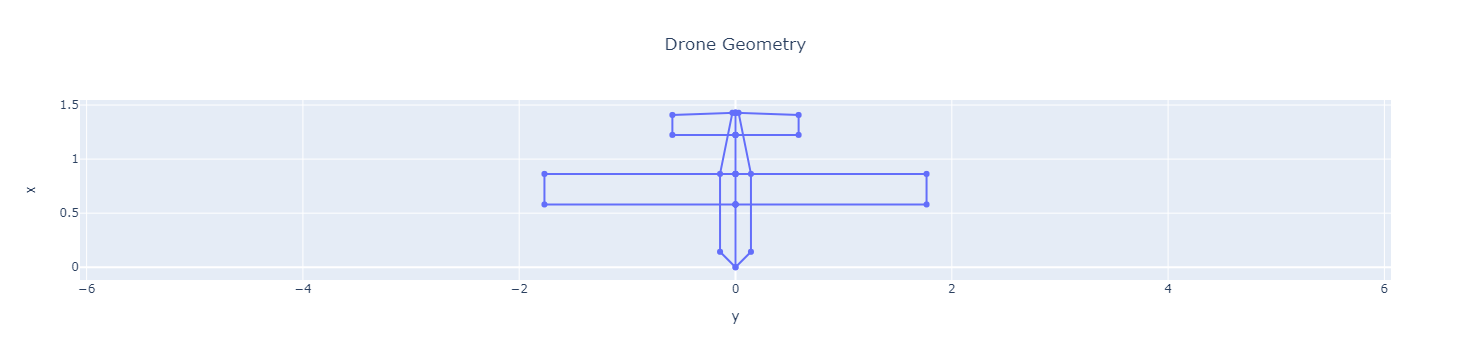

In [96]:
fig = fixedwing_geometry_plot(OUTPUT_FILE, name="Drone MDO")
fig.show()

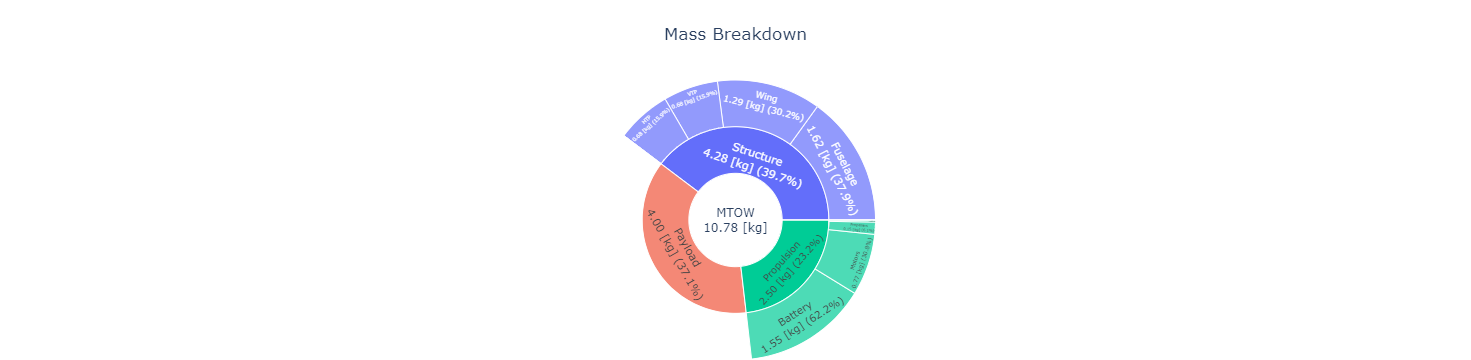

In [97]:
fig = mass_breakdown_sun_plot_drone(OUTPUT_FILE)
fig.show()

In [11]:
#fig = mass_breakdown_bar_plot_drone(OUTPUT_FILE, name="Drone MDO")
#fig = mass_breakdown_bar_plot_drone(OUTPUT_FILE, name="Drone MDO", fig=fig)
#fig.show()
# plotly.io.write_image(fig, "output_file.pdf", format="pdf")

In [12]:
#fig = energy_breakdown_sun_plot_drone(OUTPUT_FILE)
#fig.show()